# Converting GLOBAL Binary Files from XC = (-180, 180) to (0, 360)

This notebook serves as a demo for the converting existing binary files from XC = (-180,180) to XC = (0, 360)
for using the built-in interpolation of MITgcm. 

Specifically, here I convert the global_bathymetry.bin and *_IC.bin files. 


NOTE: This version uses xarray, but this could probably be accomplished with netcdf.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import xarray as xr

import glob

import time


Next, define the location of the input directory for the model. This is the same directory that holds my bathymetry and IC files that I need to convert. 

In [7]:
# define the input directory for orinal input files
input_dir = '/home/tara/Documents/SJSU/CS_185C/Project/input'

In [ ]:
coarse_bathy = os.path.join(input_dir,'global_bathymetry_1_deg.bin')
medium_bathy = os.path.join(input_dir,'global_bathymetry_half_deg.bin')

coarse_IC_loc = os.path.join(input_dir,'coarse')
medium_IC_loc = os.path.join(input_dir,'medium')

coarse_IC_files = glob.glob(coarse_IC_loc + '/*_IC.bin')
medium_IC_files = glob.glob(medium_IC_loc + '/*_IC.bin')

coarse_IC_files.sort()
medium_IC_files.sort()
    

In [9]:
# define or create a folder to store shifted input files (so you dont override the original ones)
def make_shifted_folder(res, target_dir='./'):
    shifted_input = 'input_shifted/half_degree'
    if not os.path.exists(shifted_input):
        os.makedirs(shifted_input)
    return shifted_input

coarse_shifted_input = make_shifted_folder('coarse')
medium_shifted_input = make_shifted_folder('medium')

### Generate the original (-180, 180) Model Grid with depth. 

Grab these information from previous notebooks

In [10]:
# COARSE GRID PARAMS
delX_coarse, delY_coarse = 1, 1
n_cols_coarse, n_rows_coarse = 360, 180

# MED GRID PARAMS
delX_medium, delY_medium = 1/2, 1/2
n_cols_medium, n_rows_medium = 720, 360

xgOrigin, ygOrigin = -180, -90

def get_xc_yc(delX, delY, n_cols, n_rows, xgOrigin, ygOrigin):
    xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
    yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
    XC, YC = np.meshgrid(xc, yc)

    print('Double check shape:', np.shape(xc)[0], 'x' , np.shape(yc)[0])
    print('Number of grid cells:', n_cols*n_rows)
    return xc, yc, XC, YC

print('COARSE GRID')
xc_coarse, yc_coarse, XC_coarse, YC_coarse = get_xc_yc(delX_coarse, delY_coarse, n_cols_coarse, n_rows_coarse, xgOrigin, ygOrigin)
bathy_coarse = np.fromfile(coarse_bathy,'>f4').reshape(np.shape(XC_coarse))

print('\nMED GRID')
xc_medium, yc_medium, XC_medium, YC_medium = get_xc_yc(delX_medium, delY_medium, n_cols_medium, n_rows_medium, xgOrigin, ygOrigin)
bathy_medium = np.fromfile(medium_bathy,'>f4').reshape(np.shape(XC_medium))

delR = np.array([10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50])

COARSE GRID
Double check shape: 360 x 180
Number of grid cells: 64800

MED GRID
Double check shape: 720 x 360
Number of grid cells: 259200


In [24]:
# make a file dictionary to loop over
file_prefix_dict = {'ETAN':'ETAN_2008.nc',
                    # 'THETA':'THETA_2008.nc',
                    # 'SALT':'SALT_2008.nc',
                    # 'UVEL':'UVELMASS_2008.nc',
                    # 'VVEL':'VVELMASS_2008.nc',
                    }

meta_dict = {'ETAN':[0.1, 0.7, 'viridis', 'm'],
            # 'THETA':[0, 32, 'turbo', 'm'],
            # 'SALT':[32, 37, 'viridis', 'm'],
            # 'UVEL':[-0.5, 0.5, 'seismic', 'm'],
            # 'VVEL':[-0.5, 0.5, 'seismic', 'm'],
            'DEPTH':[-5000,10, 'Blues_r', 'm'],
            }

variable_names = list(file_prefix_dict.keys())

## Helper functions

In [25]:
# Function to read in the binary files
def open_bin(input_dir, variable_name, XC, YC):

    GBL_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')
    print(os.path.join(input_dir,variable_name+'_IC.bin'))

    if variable_name == 'ETAN':
        GBL_init_grid = GBL_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        GBL_init_grid = GBL_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))

    print(f'{variable_name} GRID size: {np.shape(GBL_init_grid)}')
    return GBL_init_grid


# Function to shift the global grid to 0-360
def convert_to_0_360(ds, n_cols, x_var='longitude'):
    # relies on ds being an xarray dataset. Could be rewritten to be more general?
    ds[x_var] = np.where(ds[x_var] < 0, ds[x_var] + n_cols, ds[x_var])
    ds = ds.sortby(x_var)
    return ds


# Function to convert binary to xarray dataset, shift the grid, and return the dataset
def convert_bin_to_shifted_grid(input_dir, variable_name, XC, YC, xc, yc, n_cols, res):
    vari_ic = open_bin(input_dir, variable_name, XC, YC)

    ds_vari = xr.Dataset()

    if variable_name == 'ETAN':

        ds_vari[variable_name] = xr.DataArray(vari_ic, dims=('latitude', 'longitude'),
                                        coords={'latitude': yc, 'longitude': xc})
        ds = convert_to_0_360(ds_vari, n_cols)
        
    else:
        ds_vari[variable_name] = xr.DataArray(vari_ic, dims=('z', 'latitude', 'longitude'),
                                            coords={'z': delR, 'latitude': yc, 'longitude': xc})

        ds = convert_to_0_360(ds_vari, n_cols)

    return ds



def make_plot(ds, variable_name, res):
    fig = plt.figure(figsize=(8,3))

    if variable_name in ['ETAN', 'DEPTH']:
        C = plt.pcolormesh(ds[variable_name], vmin=meta_dict[variable_name][0], vmax=meta_dict[variable_name][1], cmap=meta_dict[variable_name][2])
    else:
        C = plt.pcolormesh(ds[variable_name][10], vmin=meta_dict[variable_name][0], vmax=meta_dict[variable_name][1], cmap=meta_dict[variable_name][2])
    plt.colorbar(C, label=variable_name+' ('+meta_dict[variable_name][3]+')',fraction=0.26)

    plt.gca().set_xticklabels([])
    plt.gca().set_xlabel('XC')
    plt.gca().set_yticklabels([])
    plt.gca().set_ylabel('YC')
    plt.title(f'{res} {variable_name}')

    plt.show()
    plt.close()


## Conversion

In [27]:
def convert_ic(input_dir, shifted_input, variable_name, XC, YC, xc, yc, n_cols, res):
    # IC files
    for variable_name in variable_names:
        ds = convert_bin_to_shifted_grid(input_dir, variable_name, XC, YC, xc, yc, n_cols, res)
        make_plot(ds, variable_name, res)
        # ravel to bin files 
        ds[variable_name].values.ravel('C').astype('>f4').tofile(os.path.join(shifted_input, f'{variable_name}_IC.bin'))
        ds.close()

def convert_bathy(bathy, shifted_input, XC, YC, xc, yc, n_cols, res):
    ds_bathy = xr.Dataset()
    ds_bathy['DEPTH'] = xr.DataArray(bathy, dims=('latitude', 'longitude'),
                                            coords={'latitude': yc, 'longitude': xc})
    ds = convert_to_0_360(ds_bathy, n_cols)
    make_plot(ds, 'DEPTH', res)

    ds.DEPTH.values.ravel('C').astype('>f4').tofile(os.path.join(shifted_input, f'global_bathymetry.bin'))
    ds.close()

Converting coarse IC files
/home/tara/Documents/SJSU/CS_185C/Project/input/coarse/ETAN_IC.bin
ETAN GRID size: (180, 360)


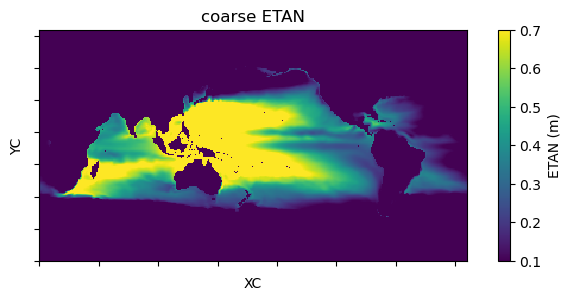

Converting medium IC files
/home/tara/Documents/SJSU/CS_185C/Project/input/medium/ETAN_IC.bin
ETAN GRID size: (360, 720)


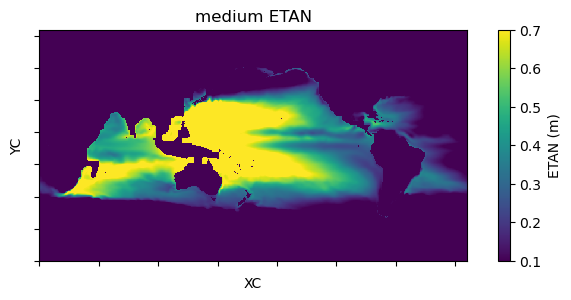

Converting coarse bathy file


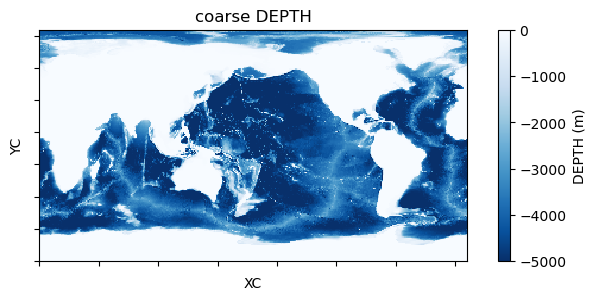

Converting medium bathy file


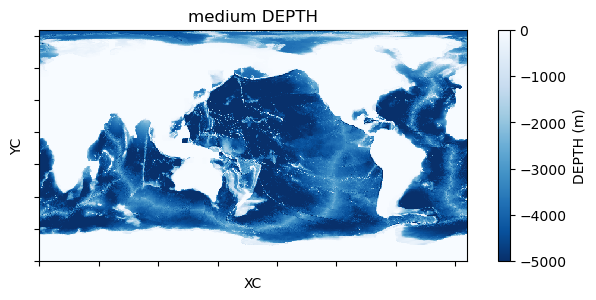

In [28]:
print('Converting coarse IC files')
convert_ic(coarse_IC_loc, coarse_shifted_input, variable_names, XC_coarse, YC_coarse, xc_coarse, yc_coarse, n_cols_coarse, 'coarse')

print('Converting medium IC files')
convert_ic(medium_IC_loc, medium_shifted_input, variable_names, XC_medium, YC_medium, xc_medium, yc_medium, n_cols_medium, 'medium')

print('Converting coarse bathy file')
convert_bathy(bathy_coarse, coarse_shifted_input, XC_coarse, YC_coarse, xc_coarse, yc_coarse, n_cols_coarse, 'coarse')

print('Converting medium bathy file')
convert_bathy(bathy_medium, medium_shifted_input, XC_medium, YC_medium, xc_medium, yc_medium, n_cols_medium, 'medium')